# 1. Introduction and hypothesis
For this final project, I am examining privacy policies to tackle problems in usable privacy. 

## Background and Motivation
Website privacy policies are often ignored or uninterpretable. Users of internet services may ignore a privacy policy due to many factors, some of which include length, density, and lack of interpretability. In fact, since we don't typically notice the effects of companies' data practices, many of us continue ignoring privacy policies.

However, this is problematic on many fronts. Most importantly, while we do not read details included in website privacy policies, we still maintain some expectation of privacy. For example, I expect that, if I've turned off location tracking, then a website will not try to infer my location. Unfortunately (for us privacy-lovers), as many computer security and privacy researchers have discovered, users' expectations and companies' practices often do not align. 

Hence, it is imperative that users have a better understanding of what companies' privacy policies actually entail. This is not a simple task though, since many companies hire lawyers to draft these policies in the way that provides the most benefit to the company. 

## Prior Work
A significant amount of effort in improving the interpretability of privacy policies is "The Usable Privacy Policy Project", a project affiliated with Carnegie Mellon University, Fordam University, Stanford University, University of Cincinnati, Penn State, Columbia University, and University of Michigan. The dataset used in this project is the Usable Privacy Policy Project's **OPP-115 Corpus**, published with their ACL 2016 paper, "The creation and analysis of a website privacy policy corpus". 

Another prominent prior work is **Polisis AI**, a machine-learning-trained-tool produced by researchers at Switzerland's Federal Institute of Technology at Lausanne, the University of Wisconsin, and the University of Michigan. According to a [Wired article](https://www.wired.com/story/polisis-ai-reads-privacy-policies-so-you-dont-have-to/), Polisis is a "website and browser extension that uses their machine-learning-trained app to automatically read and make sense of any online service's privacy policy". The tool can be found [here](https://pribot.org/). 

## Hypotheses
Building off the insights I have gained from reading about these non-trivial efforts by other researchers, I wanted to seek a better understanding of using text analysis methods we've learned in this class to answer some important questions around usability of privacy policies. These questions include:
1. If I'm a user with a privacy-related question, can I easily find out the answer to that question in a specific segment of the policy text?
2. What do privacy policies typically include? As a user, what should I expect a privacy policy to contain?
3. Are there ways to distinguish between general types of privacy policies? Are those of government-run entities different from commercial entities?
4. Given a segment, what data practice category matches the segment? 

To minimize redundancy, I elaborate on specific hypotheses for each RQ in the later sections.

The first three questions are phrased from the point of view of a user (e.g., an Amazon user). The third question can also be phrased from the point of view of someone auditing privacy policies (and may be trying to look more broadly at all policies from commercial websites). The fourth question is inspired by the Wilson et al., 2016 paper above (whose dataset is used here), and may be used in an automated tool looking for data practices of a certain website/company.

I expect to have some interpretable results since the language of privacy policies, while difficult to understand from a human point of view, is formal and may benefit from computational methods (unlike social media data, which may contain incorrect spellings and colloquialisms that add noise). However, I think it will be difficult to establish clear grouping of privacy policies, since there may be multiple dimensions in which we draw lines between different privacy policies. 

# 2. Data and methods

## Data

As mentioned above, the data used here is the `OPP-115 Corpus (ACL 2016)`. The dataset may be downloaded from the [Usable Privacy Project page](https://usableprivacy.org/data).

Quoting the website, the dataset is "a collection of website privacy policies (i.e., in natural language) with annotations that specify data practices in the text. Each privacy policy was read and annotated by three graduate students in law." 

**We cite the paper associated with this dataset here:**  
Wilson, Shomir & Schaub, Florian & Dara, Aswarth & Liu, Frederick & Cherivirala, Sushain & Leon, Pedro & Andersen, Mads & Zimmeck, Sebastian & Sathyendra, Kanthashree & Russell, N. & Norton, Thomas & Hovy, Eduard & Reidenberg, Joel & Sadeh, Norman. (2016). The Creation and Analysis of a Website Privacy Policy Corpus. 1330-1340. 10.18653/v1/P16-1126. 

### Loading the data

We load the actual text (sanitized) for each of the 115 website policies in the dataset.

In [1]:
import glob
filenames = glob.glob("./OPP-115/sanitized_policies/*.html")

company_segments = {} # keys: company name -> values: list of segments from that company's policy

for filename in filenames:
    company_name = filename.split('/')[-1].split('.csv')[0].split('_')[-1]
    file = open(filename, "r")
    file_segments = file.read().split("|||")
    # store data
    company_segments[company_name] = file_segments

print(f"Number of policies: {len(filenames)}")

Number of policies: 115


### Prepare the data

Since the text is essentially HTML, there are many tags. For simplicity, we remove all HTML tags.

In [2]:
def clean_html(raw_html):
    """
    Strip html tags from text
    """
    import re
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = re.sub(r"\s+", " ", cleantext)
    return cleantext

In [3]:
for company, segment_list in company_segments.items():
    company_segments[company] = [clean_html(segment) for segment in company_segments[company]]

## Methods

The main methods I will use are: 
1. spaCy Embedding Based Similarity (this uses word embeddings and cosine similarity underneath, as Prof. Wilkens demonstrated in class). -- for Research Question 1
2. Topic Modeling using Latent Dirichlet Allocation (LDA) -- for Research Questions 2 and 3
3. Machine Learning Classification (with GridSearch for model tuning) -- for Research Question 4

Using **spaCy word embeddings and cosine similarity** are appropriate for comparing document similarity since word embeddings capture the semantics of words of groups of words, rather than relying on token frequencies. While we don't directly use cosine similarity (spaCy uses it under the hood), we discovered in class that cosine similarities are often good for text similarity tasks.

We use **spaCy's pipeline and tools** since using open-source libraries allows us to benefit from the larger developer community's efforts. We can also take advantage of the plethora of text-processing and analysis methods provided by the spaCy API.

We use **topic modeling** since this will be key in providing a high-level sense of what our documents (i.e., privacy policies, and specifically segments of privacy policies) are about. Especially since many of us don't read privacy policies and don't even know what they contain, topic modeling, which is an unsupervised method, is particularly well-suited for our goal of better understanding these policies. Using LDA is beneficial for us since the topical sparsity will help when it comes to interpretability, an overarching theme of this project.

Finally, we use **machine learning classifiers (specifically Logistic Regression and Random Forest)** for our classification problem, since these two methods have performed well in the various text analysis efforts throughout the course. We **cross-validate** to reduce the chance of overfitting, and also use **GridSearchCV** to tune the parameters of our models, since this may often lead to improvements in performance.

# 3. Results + 4. Discussion

*We now interleave our dialogue with code to step through the techniques used to solve each of our four main research questions. Discussions will be appended to the code and results of each section.*

## *RQ 1: If I'm a user with a privacy-related question, can I easily find out the answer to that question in a specific segment of the policy text?*
## METHOD: Embedding-based segment similarity using spaCy.

As a reminder, we hypothesize that using embedding-based similarity to find the most similar policy segment to our user's question will allow us to easily identify a segment that answers the question (the top-matching segment makes sense).

In [4]:
import spacy
nlp = spacy.load("en_core_web_lg") # We use the large model for the embeddings

Suppose I'm a user with a privacy-related question (as prefaced in the RQ above). I want to scan through a privacy policy to answer this question and see the specific chunk of text, quoted from the policy. In the cell below, we create a realistic question as our `query`.

In [6]:
query = "Do you share my information with third parties?"
query_obj = nlp(query)

For this project, we will focus on one company's privacy policy and see if we can find a similar statement relevant to our query. This method can be trivially applied to other policies by substituting the company name (although the string also includes the .com.html at the end) in the cell below.

We iterate through every segment in Amazon's policy and store the segment's similarity score compared to our query.

In [7]:
amazon_policy_segments = company_segments['amazon.com.html']
segment_similarities = {} # maps segment_index -> segment_similarity
for i, segment in enumerate(amazon_policy_segments):
    # generate sentence embedding
    segment_obj = nlp(segment)
    segment_similarity = query_obj.similarity(segment_obj)
    # store similarity for this segment
    segment_similarities[i] = segment_similarity

Now, we sort the segments by their similarity to our query.

In [8]:
sorted_similarities = sorted(segment_similarities.items(), key=lambda pair: pair[1])

**We look at the two least-similar segments first to see if they are indeed dissimilar and therefore irrelevant to a user.**

In [9]:
print(sorted_similarities[:2])

[(0, 0.5536039401230849), (35, 0.7504127733259123)]


In [10]:
print(amazon_policy_segments[0])

Amazon.com Privacy Notice 


In [11]:
print(amazon_policy_segments[35])

 Co-branded and Joint Offerings Examples of businesses with which we offer joint or co-branded products and other offerings include Starbucks, OfficeMax, Verizon Wireless, Sprint, T-Mobile, AT&T, J&R Electronics, Eddie Bauer and Northern Tool + Equipment. 


**We then look at the two most-similar segments to see if they would be helpful to the user**

In [12]:
print(sorted_similarities[-2:])

[(2, 0.9388802272257288), (16, 0.9403845018250548)]


In [13]:
print(amazon_policy_segments[16])

 With Your Consent: Other than as set out above, you will receive notice when information about you might go to third parties, and you will have an opportunity to choose not to share the information. 


In [14]:
print(amazon_policy_segments[2])

Amazon.com knows that you care how information about you is used and shared, and we appreciate your trust that we will do so carefully and sensibly. This notice describes our privacy policy. By visiting Amazon.com, you are accepting the practices described in this Privacy Notice. What Personal Information About Customers Does Amazon.com Gather? What About Cookies? Does Amazon.com Share the Information It Receives? How Secure Is Information About Me? What About Third-Party Advertisers and Links to Other Websites? Which Information Can I Access? What Choices Do I Have? Are Children Allowed to Use Amazon.com? Does Amazon.com Participate in the Safe Harbor Program? Conditions of Use, Notices, and Revisions Examples of Information Collected 


# Discussion of RQ 1.

From the results printed above, we see that the least-similar segments indeed do not answer our query, "Do you share my information with third parties?".

We also see that the most similar segment (segment index = 16) does indeed provide some useful information to our user! Precisely, the answer is "you will receive notice when information about you might go to third parties, and you will have an opportunity to choose not to share the information.". Considering the similarities in words used ("information", "third parties", "share"), this result makes sense. Also, "go to" and "share ... with" have similar semantic meanings, which also may have contributed to the high similarity score. 

I think this worked particularly well due to the limited range of ways one could phrase this question and also the appropriate response. "Third parties" is a particularly common phrase in third parties, and is almost always mentioned within the context of: what information is shared with whom.

We also gain confidence in this technique upon observing that the least-similar segments do not reveal any useful information regarding information-sharing with third parties.

One limitation here is visible in the "Other than as set out above" substring in the most similar segment (segment 16). There may be additional information in other segments that the user would need to know to truly understand third parties' potential to obtain personal information. Two solutions to this limitation include: (1) changing how segments are divided, and also (2) running further analysis on the most-similar segments. 

However, if we set a cap on the most-similar segments, we may unintentionally exclude important details. The most useful way to present this information would be in presenting the entire document and highlighting the text that corresponds with this most-similar segment. 

## *RQ 2: What do privacy policies typically include? As a user, what should I expect a privacy policy to contain?*

With this research question, we attempt to find some way to summarize/generalize privacy policies. 

Our hypothesis is that there are discrete topics that compose each privacy policy segment. We hope to observe this in the topics created and the correlation plot between generated topics.

## METHOD: Topic Modeling
Topic modeling with LDA at the segment granularity will help us create these topics.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pandas as pd
import random

We first grab all segments from all 115 policies.

In [16]:
all_segments = [segment for seg_list in company_segments.values() for segment in seg_list]
print(f"Total number of segments: {len(all_segments)}")

Total number of segments: 3792


The following cells perform the topic modeling we learned in lecture. We increase the number of iterations to ensure convergence.

In [17]:
vectorizer = CountVectorizer( # Token counts, not normalized (sklearn normalizes later)
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
    min_df = 0.001, 
    max_df = 0.3   # even smaller since a lot of terms like "privacy", "policy", etc. will not be super useful in creating distinct topics.
)

X = vectorizer.fit_transform(all_segments)
print("Feature matrix shape:", X.shape)

Feature matrix shape: (3792, 2572)


In [18]:
lda = LatentDirichletAllocation(
    n_components=20, # Number of topics to find
    n_jobs=-1,       # Use all CPU cores
    verbose=1,       # Print progress
    max_iter=30,     
    evaluate_every=0 # Set >=1 to test for convergence (slow, but can stop iteration)
)

lda.fit(X)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(evaluate_every=0, max_iter=30, n_components=20,
                          n_jobs=-1, verbose=1)

In [19]:
def print_top_words(model, feature_names, n_top_words):
    """
    Prints the top words in every inferred topic.
    """
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [20]:
print_top_words(lda, vectorizer.get_feature_names(), n_top_words=10)

Topic 0: sites policy party websites site links practices policies website services
Topic 1: barnes noble research track personal receive signals education currently mail
Topic 2: site cookies web browser collect website ip data computer used
Topic 3: email address fsd fool account company friend services games personal
Topic 4: services service party providers social provide collect share media google
Topic 5: address contact email mail personal child medianews com personally questions
Topic 6: account services provide user personal users time content features site
Topic 7: children com 13 age collect personal website websites online does
Topic 8: device mobile services location collect apps applications including app application
Topic 9: personal share company policy business companies affiliates parties party sell
Topic 10: health kaleida allstate personal request delete written law business records
Topic 11: states united honda services personal provide online country laws request


From a quick scan through these topics, we see some interesting groupings.  
For instance, topic 2 seems heavily centered on cookies and web-tracking.  
Topic 8 may be related to mobile devices and location tracking.   
Topic 7 seems to refer to minors and childrens' privacy.  

While these topics seem interesting and intuitive within the context of privacy concerns, we want to learn more about the policies, given these topics. We first look at correlations between topics to get a sense of policy structure.

In [21]:
doc_topic_matrix = lda.transform(X)
print("Doc-topic matrix shape:", doc_topic_matrix.shape)

Doc-topic matrix shape: (3792, 20)


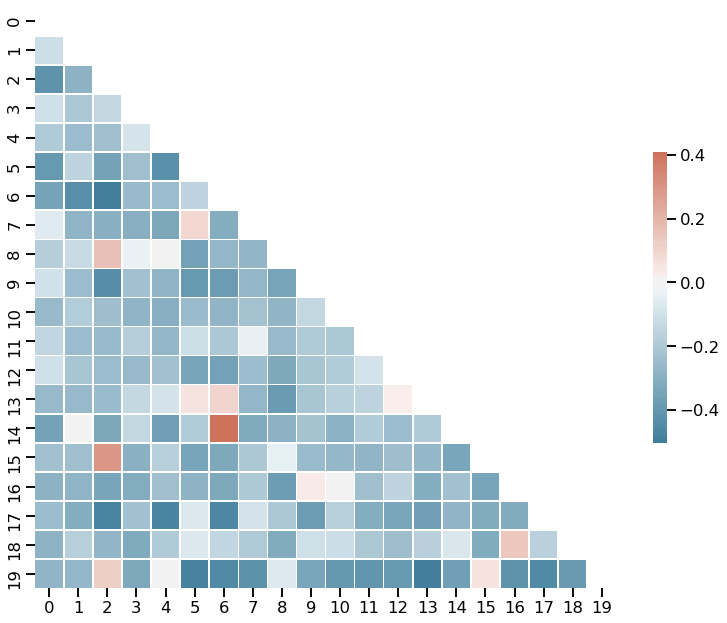

In [25]:
# Correlation plot
#  Adapted from Seaborn docs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from   sklearn.preprocessing import StandardScaler

sns.set_context('talk')
corr = np.corrcoef(doc_topic_matrix.T)

corr_std = StandardScaler().fit_transform(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_std, 
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.tight_layout()
plt.show()

We see that 2 and 15 are positively correlated, while 2 and 5 are negatively correlated.

Looking at Topics 2 and 15, they both seem to be related to cookies and web browsing/web-tracking, so it makes sense that they are often found in the same segment.

Topics 2 and 5, negatively correlated, do not occur in the same segment as often. Topic 2 is related to cookies and web-tracking, while topic 5 refers to personal information like email, addresses, and potentially phone numbers.

**Taking these topics a bit further, we observe that there are four main domain endings.**
These domain endings are: ".com", ".org", ".edu", and ".gov". These seem to be related to organization type (e.g., commercial vs government), so we then ask, do some organization types speak more to certain topics than other organization types? For instance, do commercial organizations talk more about ads and web-tracking than educational services?

This leads us to our third research question...
## *RQ 3. Are there ways to distinguish between general types of privacy policies? Are those of government-run entities different from commercial entities?*

We hypothesize that there will be some differences between policies of different organization types, especially between government-run entities and commercial entities since the latter is more consumer-facing and typically involves more third-party advertising. However, we also hypothesize that the difference may be slightly blurred along several topics, especially since most policies will talk about "third parties", "personal information", and "location tracking" to some extent. 

We first generate the domain for each of our segments and store them in a DataFrame.

In [28]:
company_names = company_segments.keys()

In [29]:
segments_column = []
company_column = []
domain_column = []

for company in company_names:
    for segment in company_segments[company]:
        segments_column.append(segment)
        company_column.append(company)
        domain_column.append(company.split('.')[-2])

In [30]:
policy_seg_df = pd.DataFrame()
policy_seg_df['segment'] = segments_column
policy_seg_df['company'] = company_column
policy_seg_df['domain'] = domain_column

In [31]:
policy_seg_df.head()

,segment,company,domain
0,"Privacy Policy Last Modified: March 25, 2013",latinpost.com.html,com
1,"This is the privacy policy (""Privacy Policy"") ...",latinpost.com.html,com
2,1. When This Privacy Policy Applies. This Pri...,latinpost.com.html,com
3,This Privacy Policy will remain in full force ...,latinpost.com.html,com
4,2. U.S. Governing Law; Safe Harbor. The Site ...,latinpost.com.html,com


We now plot, for each topic, a bar with the mean topic probability for every organization. Bar height indicates probability of segments in the domain category (e.g., com) relating to that specific topic.

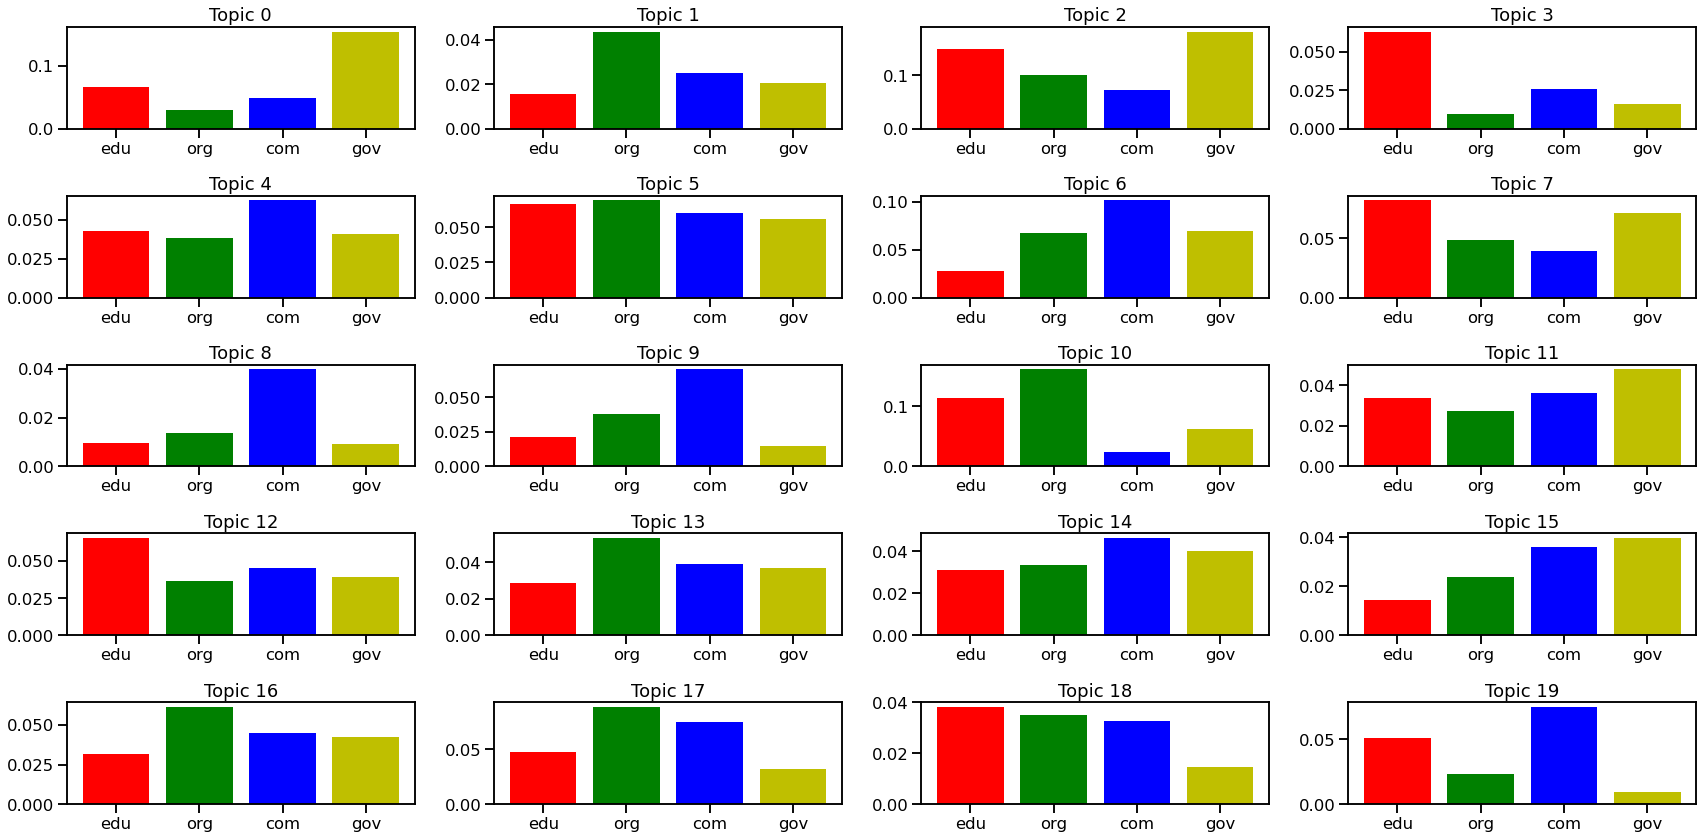

In [33]:
n_topics = doc_topic_matrix.shape[1]

n_cols = 4
n_rows = int(n_topics/n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(24, 12))
axs = axs.ravel()

unique_domain_endings = list(set(policy_seg_df['domain'].values))
for topic in range(n_topics):
    topic_data = doc_topic_matrix[:, topic]
    topic_means = []
    for domain_ending in unique_domain_endings:
        mask = [domain_ending == d for d in policy_seg_df['domain'].values]
        topic_mean = np.mean(topic_data[mask])
        topic_means.append(topic_mean)
    axs[topic].bar(unique_domain_endings, topic_means, color=['r', 'g', 'b', 'y'])
    axs[topic].set_title(f'Topic {topic}')
plt.tight_layout()
plt.show()

Here, we point out three interesting observations. 

* In the plot for Topic 19, we see that commercial websites (.com) are most strongly associated with the topic. Topic 19 seems related to advertising, which makes sense as commercial entities benefit largely (in profits) from ad services. .org, and .gov are slightly less associated with this topic.

* In the plot for Topic 9, we see that .com is significantly more associated with this topic, which, upon looking at the most common words for this topic, may be related to business and affiliates. This makes sense given that "business" and "affiliates" are typically used when referring to commercial entities.

* In the plot for Topic 10, we see that ".org" websites are strongly associated with this topic (vs. other types of websites). Keywords imply that this topic may be related to insurance, health, and perhaps personal care services. Since .org may be associated with ensurance and health organizations, this also makes sense.

## Discussion for RQ 2 and 3

Utilizing text, heat map, and bar graph results, we confirm our hypotheses and propose plausible responses to our research questions.

**RQ 2: What do privacy policies typically include? As a user, what should I expect a privacy policy to contain?**
**Hypothesis:** There are discrete topics that compose each privacy policy segment, but there is likely some overlap between topics.

From the top words listed for each of the 20 topics, we identified that there are clear topics such as "location tracking", "cookies/web-tracking", and policies concerning minors/children. We also note here that terms like "cookies", "websites" still occur in multiple topics, but this overlap occurs pretty infrequently. I think this separation (which is good) is due to the `max_df` we intentionally set to a lower value in our vectorization. However, one limitation to this approach is that the `max_df` parameter may need to be set heuristically, which makes it difficult to determine what a good threshold for vectorization is.

We also examined the correlation between topics in segments of the privacy policies to visually represent overlaps in topics. More interestingly, we observe that certain topics do not correlate with each other within policy segments. The example we point out is the negative correlation between the "cookies" topic and the email-address/personal information topic. These insights may be useful in guiding what aspects of privacy policy are related to each other and what a user may need to consider when thinking about "cookies" (i.e., they might not need to consider policy regarding personal information when thinking about cookies). 

**RQ 3: Are there ways to distinguish between general types of privacy policies? Are those of government-run entities different from commercial entities?**
**Hypothesis:** There are some differences between policies of different organization types, especially between government-run entities and commercial entities since the latter is more consumer-facing and typically involves more third-party advertising. However, we also hypothesize that the difference may be slightly blurred along several topics, especially since most policies will talk about "third parties", "personal information", and "location tracking" to some extent.

Observing the bar plots, the three points we made for topics 19, 9, and 10 demonstrate that there are intuitive differences between organization types for specific topics. However, some topics, like topic 12 (likely relating to secure data protected against unauthorized access), is almost equally present across all organization types. This confirms our second hypothesis that the difference is blurred/less prevalent in certain topics. 

One concerning limitation in this method is that there are significantly more .com websites than other websites. This can be observed by quickly scanning through the list of .html files. This is an inherent limitation in the dataset we use, but this can be resolved in the future with more data gathering and labeling.

**Moving onto our final research question, we increase the granularity from topic to data practice, and attempt to predict data practices in the policy text segments.**

## RQ 4: *Given a segment, what data practice category matches the segment?*
## METHOD: Using machine-learning classification to aid privacy policy scanning tools

A data practice category is defined in the paper as a category of data practice specified by a privacy policy. The paper proposes the following categories:
1. First Party Collection/Use
2. Third Party Sharing/Collection
3. User Choice/Control
4. User Access, Edit, & Deletion
5. Data Retention
6. Data Security
7. Policy Change
8. Do Not Track
9. International & Specific Audiences
10. Other

Each segment is assigned a category type, and we hypothesize that we can reliably predict the data practice category type of each segment, since segment text contains key words and phrases easily linked to one of these categories (e.g., "third party" -> the 2nd category above).

In [34]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

In [35]:
def add_datapoints_to_lists(annotation_file_name, company_segments, segments, categories):
    """
    Parses category data from annotation file with `annotation_file_name` and joins it with segment text data from `company_segments`.
    The list of segments and their corresponding category names (for data practices) are then appended to the `segments` and `categories` lists.
    """
    column_names = ['annotationID', 'batchID', 'annotatorID', 'policyID', 'segmentID', 'categoryName', 'attributeValuePairs', 'policyURL', 'date']

    # load the annotations data and drop duplicates for simplification
    annotations_df = pd.read_csv(annotation_file_name, header=None, names=column_names)
    cleaned_annotations_df = annotations_df.drop(['batchID', 'policyURL', 'annotationID', 'date', 'attributeValuePairs', 'annotatorID'], axis=1).drop_duplicates(subset=['policyID', 'segmentID'])

    # combine the annotated categories with the segment text
    company_name = annotation_file_name.split('/')[-1].split('.csv')[0].split('_')[-1] + ".html" # to index the company_segments dictionary
    company_seg_list = company_segments[company_name]

    # add the segments to the dataframe
    cleaned_annotations_df['segmentText'] = [company_seg_list[i] for i in cleaned_annotations_df['segmentID']]

    # add the segment text and categories (labels we will predict) to the lists we're cumulating
    segments.extend(cleaned_annotations_df['segmentText'])
    categories.extend(cleaned_annotations_df['categoryName'])
    
    return segments, categories

We first generate our features and labels. We use our custom-defined function above to merge information from the `annotations/` with the policy text segments we used in the earlier sections.

In [36]:
segments = []
categories = []
for annotation_file_name in glob.glob('./OPP-115/annotations/*.csv'):
    segments, categories = add_datapoints_to_lists(annotation_file_name, company_segments, segments, categories)

We now have our segments and their labels (i.e. the data practice categories).

In [37]:
print(f"Created {len(segments)} segments and {len(categories)} categories")

Created 3792 segments and 3792 categories


The category types and counts present in our dataset are displayed below.

In [38]:
Counter(categories)

Counter({'Other': 973,
         'First Party Collection/Use': 1097,
         'Third Party Sharing/Collection': 663,
         'User Choice/Control': 308,
         'International and Specific Audiences': 277,
         'Data Security': 190,
         'Policy Change': 103,
         'User Access, Edit and Deletion': 123,
         'Do Not Track': 21,
         'Data Retention': 37})

We then proceed with Tfidf vectorization and train a Logistic Regression classifier, since this process has generalized well across various applications in our coursework and also in other classification tasks.

In [39]:
vectorizer = TfidfVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
    min_df = 0.001, 
    max_df = 0.3    
)

In [40]:
X = vectorizer.fit_transform(segments)
y = categories

In [41]:
cross_val_scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='accuracy')
print("Cross validation scores of untuned Logistic Regression: ", cross_val_scores)

Cross validation scores of untuned Logistic Regression:  [0.7088274  0.68642951 0.66886544 0.72163588 0.68733509]


In [42]:
print("Average score of untuned Logistic Regression Model:", round(np.mean(cross_val_scores), 5))

Average score of untuned Logistic Regression Model: 0.69462


We see that the untuned Logistic Regression accuracy is better than 50%, but it is not great. We try tuning the Logistic Regression parameters to improve the accuracy score.

In [43]:
logistic_grid = {"C": np.logspace(-3,3,7), "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

In [44]:
logistic_clf_gridsearch = GridSearchCV(LogisticRegression(max_iter=1000), logistic_grid, cv=5, n_jobs=-1, verbose=2)
logistic_clf_gridsearch.fit(X,y) # X_scaled is the scaled feature matrix for the token-based classification

print("Tuned hyperparameters:",logistic_clf_gridsearch.best_params_)
print("Accuracy:",logistic_clf_gridsearch.best_score_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   43.8s finished


Tuned hyperparameters: {'C': 1.0, 'solver': 'newton-cg'}
Accuracy: 0.6946186657211093


In [45]:
tuned_cross_val_scores = cross_val_score(LogisticRegression(C=1.0, solver='saga'), X, y, cv=5, scoring='accuracy')
print("Average score of tuned Logistic Regression: ", round(np.mean(tuned_cross_val_scores), 5))

Average score of tuned Logistic Regression:  0.69515


The benefits of tuning the Logistic Regression classifier are minimal: a 0.001 improvement in accuracy.

We also look into scaling our feature matrix, and try tuning the "C" parameter, since this parameter typically has the most impact on classifier accuracy.

In [46]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X.toarray())

In [47]:
scaled_cross_val_scores = cross_val_score(LogisticRegression(max_iter=1000), X_scaled, y, cv=5, scoring='accuracy')
print("Cross validation scores of untuned Logistic Regression: ", round(np.mean(scaled_cross_val_scores),5))

Cross validation scores of untuned Logistic Regression:  0.62921


In [48]:
logistic_grid = {"C": np.logspace(-2,2,5)}

In [49]:
logistic_clf_gridsearch = GridSearchCV(LogisticRegression(max_iter=1000), logistic_grid, cv=5, n_jobs=-1, verbose=2)
logistic_clf_gridsearch.fit(X_scaled,y) # X_scaled is the scaled feature matrix for the token-based classification

print("Tuned hyperparameters:",logistic_clf_gridsearch.best_params_)
print("Accuracy:",logistic_clf_gridsearch.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  3.4min remaining:   17.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.4min finished


Tuned hyperparameters: {'C': 0.01}
Accuracy: 0.6613889265489586


Scaling and retuning decreases the score (the highest accuracy is lower than the overall highest accuracy we've seen so far with logistic regression). One reason for this may be due to the normalization already provided by using a Tfidf vectorizer (so scaling does not help our classification). 

### Next, we'll try a Random Forest Classifier

We try the untuned and also tuned Random Forest classifiers and generate cross-validated accuracy scores for each iteration.

In [50]:
rf_cross_val_scores = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='accuracy')
print("Cross validation scores of untuned Random Forest Classifier: ", round(np.mean(rf_cross_val_scores), 5))

Cross validation scores of untuned Random Forest Classifier:  0.69673


In [51]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

rf_grid = {'n_estimators': n_estimators,
           'bootstrap': bootstrap, 
           'max_features': max_features}

In [52]:
rf_clf_gridsearch = GridSearchCV(RandomForestClassifier(), rf_grid, cv=5, n_jobs=-1, verbose=2)
rf_clf_gridsearch.fit(X, y) # X_scaled is the scaled feature matrix for the token-based classification

print("Tuned hyperparameters:",rf_clf_gridsearch.best_params_)
print("Accuracy:",rf_clf_gridsearch.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished


Tuned hyperparameters: {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 1000}
Accuracy: 0.7115003424169422


In [53]:
tuned_rf_model = RandomForestClassifier(bootstrap= False, max_features= 'sqrt', n_estimators= 600)
rf_cross_val_scores = cross_val_score(tuned_rf_model, X, y, cv=5, scoring='accuracy')
print("Cross validation scores of tuned Random Forest Classifier: ", round(np.mean(rf_cross_val_scores), 5))

Cross validation scores of tuned Random Forest Classifier:  0.71044


Since the tuned random forest classifier produced the highest cross-validated accuracy score (0.710 vs 0.695 from the tuned Logistic Regression), we choose this model and further explore its limitations in the following discussion section.

## Discussion of these models
We incorporate more code into the discussion of these results since we would like to get a better understanding of the model while detailing its inaccuracies/limitations.

#### Interpreting the results of this model.
Let's first take a closer look at the accuracy scores, specifically those for the individual classes (rather than an aggregated accuracy score across all classes).

We perform a train_test split instead of the cross-validation from above so we can delve deeper into the predictions the model generates. We use the same tuned Random Forest model (stored in a variable in the previous cell) for our discussion.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # shuffle = False so we can look at some incorrect predictions below.
trained_model = tuned_rf_model.fit(X_train, y_train)
predictions = trained_model.predict(X_test)

In [55]:
print(classification_report(y_test, predictions))

                                      precision    recall  f1-score   support

                      Data Retention       0.67      0.33      0.44         6
                       Data Security       0.84      0.73      0.78        37
                        Do Not Track       0.67      0.50      0.57         4
          First Party Collection/Use       0.64      0.84      0.73       217
International and Specific Audiences       0.93      0.74      0.82        54
                               Other       0.67      0.66      0.67       201
                       Policy Change       0.81      0.76      0.79        17
      Third Party Sharing/Collection       0.73      0.70      0.72       130
      User Access, Edit and Deletion       0.73      0.35      0.48        31
                 User Choice/Control       0.76      0.47      0.58        62

                            accuracy                           0.70       759
                           macro avg       0.75      0.61     

Here, we see that some classes have much lower f1-scores than other classes. For example, we see that the **Data Retention** category has a f1-score of 0.44, which is significantly lower than the others. Lower accuracies tend to be correlated with classes with lower "support" values, aka less datapoints. This imbalance in f1-scores may be due to class imbalances, a significant problem in developing classification models.

This is a limitation posed by the dataset we are using. One could try different sampling techniques or label more data to resolve class imbalances.

### Incorrect prediction samples
Now, we take a closer look at some texts that are misclassified, and generalize what types of misclassifications are occurring in our model.

In [56]:
num_incorrect_predictions_printed = 0
for i in range(len(predictions)):
    if predictions[i] != y_test[i]:
        print("TEXT:", segments[len(y_train) + i])
        print(f"EXPECTED: {y_test[i]}. \tPREDICTED: {predictions[i]}")
        print()
        num_incorrect_predictions_printed += 1
    if num_incorrect_predictions_printed == 5: # print only 5 incorrect predictions
        break

TEXT:  Because we are one big, happy family, The Motley Fool and its subsidiaries may share information for site administration or order fulfillment, and to notify you of products and services that may interest you. 
EXPECTED: Third Party Sharing/Collection. 	PREDICTED: First Party Collection/Use

TEXT: Personalized areas of our sites, such as My Fool, are password-protected. Only you have access to these password-protected areas. Do not share your passwords with anyone. The Motley Fool will never ask you for your password in an unsolicited phone call or email. If you are using a computer to which others have access, such as one in a computer lab, Internet cafe, or public library, always remember to log out and close your browser window when leaving our site. 
EXPECTED: Data Security. 	PREDICTED: First Party Collection/Use

TEXT:  Data Retention Upon your request, we will remove your personal information from the website but we will retain and use your information as necessary to compl

One common misclassification we already see is the confusion between "Third Party Sharing/Collection" and "First Party Collection/Use". This confusion makes sense, since both data practices relate to collection (either from a first or third party) of data. The use of pronouns (e.g., "We may also provide...") may also generate some confusion in the model.

#### Confusion Matrix

From the initial observations generated above, there may be patterns in misclassifications (e.g., class A is often confused with class B). Noting the limitations of looking at samples of incorrect predictions (it does not make sense to look at all the incorrect predictions, but we do want to be comprehensive in examining mispredictions). 

Hence, we generate a confusion matrix to get a better understanding of the misclassifications.

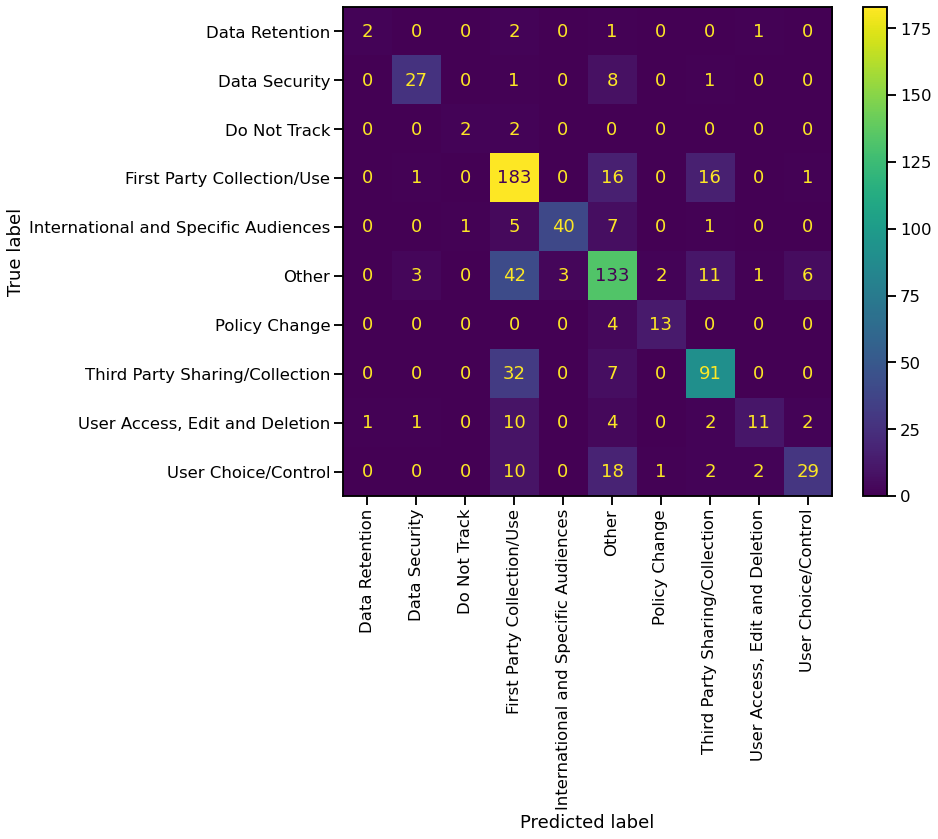

In [57]:
f, ax = plt.subplots(figsize=(11, 9))
plot_confusion_matrix(tuned_rf_model, X_test, y_test, xticks_rotation=90, ax=ax)

With this confusion matrix, we note that most non-diagonal entries are 0 or pretty close to 0 (which indicates our model is making a non-trivial number of correct predictions). 

However, we see that **First Party Collection/Use** is often confused with **Third Party Sharing/Collection** (as we saw in our text samples earlier). Our inference for the sources of this confusion are detailed above. For these types of misclassifications, one may try to improve the model by adding POS tags and additional features from spaCy that help differentiate between first and third-party subjects. Better feature engineering could also selectively reduce misclassifications between specific categories.

*We also note another interesting and significant misclassification/confusion:*  

**First Party Collection/Use** with **Other**: "Other" is defined as "additional sub-labels for introductory or general text, contact information, and practices not covered by other categories.".
    * Looking across the "Other" column and rows, we see there is more confusion with this category in general. This is a limitation inherent in the pre-defined categories, so one might try to improve this classification task by further defining some categories within "Other".



# 5. Conclusion

We now wrap up the three main discussions from above by consolidating support for hypotheses, limitations, and suggestions for future work to tackle these limitations.

The questions guiding this project (copied from above) are:
1. If I'm a user with a privacy-related question, can I easily find out the answer to that question in a specific segment of the policy text?
2. What do privacy policies typically include? As a user, what should I expect a privacy policy to contain?
3. Are there ways to distinguish between general types of privacy policies? Are those of government-run entities different from commercial entities?
4. Given a segment, what data practice category matches the segment?

### RQ1. 
Our hypothesis that the embedding-based similarity could provide a text segment that answered the user's query was supported by our sample with Amazon's privacy policy. The main limitation we discussed in that section was that the selected segment may refer to another part of the policy not included in the returned text. A user would benefit from seeing the segment that had the highest similarity score with the query, and also any potential segments referenced in the selected segment. 

Future work (in application development) could resolve this by displaying the entire policy text and highlighting the segment within the text to allow a user to see other segments juxtaposed with the selected segment. On the NLP development side, one could return the k-most-similar segments, but this would pose an issue in determining the best k.

### RQ2 and RQ3. 
We hypothesized that there are discrete topics that compose privacy policies, including those related to location data, cookies, and contact information. This was vaguely supported by the topics we generated using topic modeling with LDA; we observed the plausible existence of these policies by tgenerating the top words for each topic. 

Related to Q3, we hypothesized that there would be differences between the privacy policies of government-run entities and commercial entities, and noted that, while there are likely observable differences, there may be less-clear boundaries between different types of organizations. The topic means we generated for every type of organization, per topic, demonstrated this mixture of results: some topics, like ad servies, showed a clear distinction between commercial entities and government/education entities, but other topics like ensuring data security against unauthorized access (topic 17) were equally present in all organization types.

Some limitations include the smaller quantity of data from non-commercial entities. This makes our aggregate calculations and observations less reliable, since some means are comprised of a few datapoints. Future works may get around this issue by gathering more privacy policies from .gov and .edu websites.

### RQ4. 
We hypothesized that we can use machine-learning classification techniques to predict a category of data practice given a policy segment. From our analyses, many predictions are correct (overall, ~70% with the tuned Random Forest model). However, we note two limitations: 

1. Class imbalances may skew our results (making the accuracy seem high despite the model being biased towards certain classes). We propose that this limitation may be resolved by implementing additional sampling techniques or by labeling more policy data from less-frequent classes.
2. Confusion between several categories, like the **First Party Collection/Use** and **Third Party Sharing/Collection** classes. As we observed by looking at sample texts, this is a limitation presented by the similar language of segments with these labels. Future work may augment the input features with spaCy POS tags or by implementing other feature-engineering steps to specifically target the common misclassifications (features that specifically differentiate first-party from third-party subjects). 

**Overall**, we see promising results in applying NLP to privacy policies. The language is standardized, lending itself well to text analysis techniques, yet the length and lack of readability motivates research to improve the interpretability of these privacy policies. 

This project explores several core research questions motivated by a user's point of view, and demonstrates that techniques like word-embedding-based similarities, topic modeling, and machine learning classification models can enhance the research area of usable privacy.

# 6. Acknowledgements 

Even though this isn't quite a fully-fledged, eloquent paper ready for submission, I appreciate the acknowledgments section. This is a slightly more informal version of acknowledgments, but still written with the same intentions.

Thank you to the entire INFO 3350 course staff for your support and guidance throughout the semester. This final project was an especially amazing opportunity to explore my own idea, which is closely related to my interests in Usable Privacy and Computer Security (hoping to pursue this in graduate school actually!). I hope my analysis is interesting for you to follow along!